# Import

In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

import pickle as pkl

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# 1. Données USPS

### Import des données USPS

In [2]:
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

### Affichage en t-SNE des données

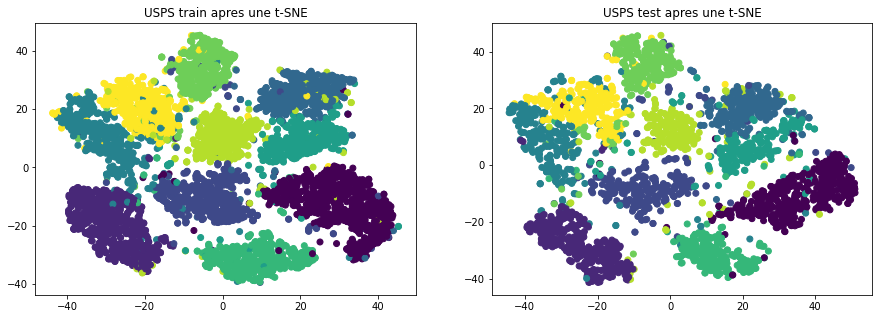

In [3]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)

repre_2D = tsne.fit_transform(X_train)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("USPS train apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

repre_2D = tsne.fit_transform(X_test)

plt.subplot(122)
plt.title("USPS test apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)
plt.show()

### Définition d'une architecture 

100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.47it/s]


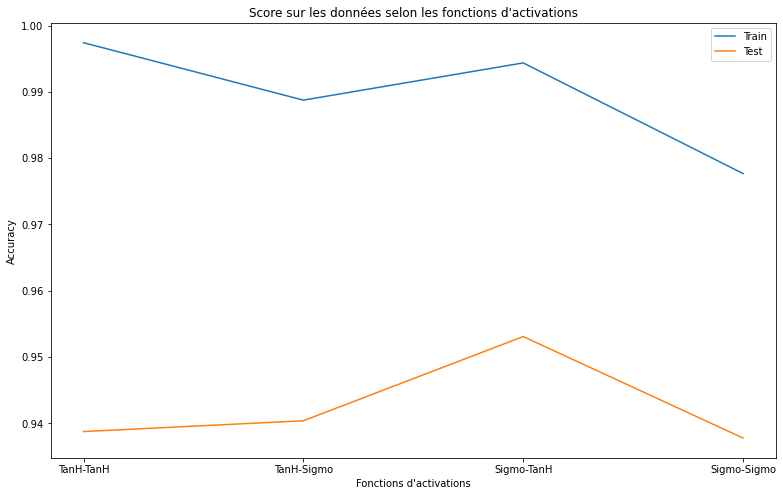

In [15]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 20
epochs = 50

scores_tr = []
scores_te = []
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()
activations = [[TanH,TanH],[TanH,sigmoide],[sigmoide,TanH],[sigmoide,sigmoide]]
fonctions = ["TanH-TanH","TanH-Sigmo","Sigmo-TanH","Sigmo-Sigmo"]

for activa in activations:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)

    network_layers = [lineaire_1,activa[0],lineaire_2,activa[1],lineaire_3,softmax]
    network = Sequentiel(network_layers)

    opti = Optim(network,CE,1e-2)
    opti.SGD(X_train,Y_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(X_train,Y_train))
    scores_te.append(opti.getNetwork().accuracy(X_test,Y_test)) 
    
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données selon les fonctions d'activations")
plt.xlabel("Fonctions d'activations")
plt.ylabel("Accuracy")
plt.plot(fonctions,scores_tr)
plt.plot(fonctions,scores_te)
plt.legend(["Train","Test"])
plt.show()

- On remarque qu'en mettant une sigmoide pour la premiere couche et une TanH pour la deuxieme couche donne des resultats plus interessants vu que la generalisation sur le probleme est plus grande (97% train , 93% test) par rapport aux autres combinaisons de fonction d'activations.

### Evaluation du réseau optimal

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  2.97it/s]


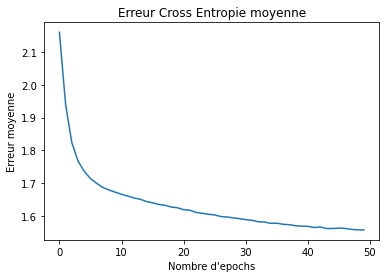

Accuracy  :  0.9733504575373254
Accuracy sur le train :  0.9733504575373254
Accuracy sur le test :  0.9341805148256761


In [17]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,sigmoide,lineaire_2,sigmoide,lineaire_3,softmax]
network = Sequentiel(network_layers)

opti = Optim(network,CE,1e-2)
opti.SGD(X_train,Y_train,batch_size,epochs)
opti.affichage(X_train,Y_train)


print("Accuracy sur le train : ",opti.getNetwork().accuracy(X_train,Y_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(X_test,Y_test))


net_to_graph(network, net_name="networks_images/network_MC_USPS", horizontal=True)

In [18]:
nb_classes = 10

Y_pred = opti.getNetwork().predict(X_train,nb_classes)

kmeans = KMeans(n_clusters=nb_classes, random_state=0, max_iter=1000).fit(X_train)
yhat = kmeans.labels_

y_cluster_pred = np.zeros(len(X_train))
indices = np.arange(len(X_train))

for cluster in range(nb_classes):

    vals, counts = np.unique(Y_train[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]

    y_cluster_pred[indices[yhat == cluster]] = val_maj

    
y_cluster_pred = np.array(y_cluster_pred.astype("int"))


print("TRAIN\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(Y_train,y_cluster_pred))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(Y_pred,y_cluster_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(Y_train,y_cluster_pred))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(Y_pred,y_cluster_pred))

print("--------------------------------------------")


Y_pred = opti.getNetwork().predict(X_test,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_test)
yhat = kmeans.labels_

y_cluster_pred = np.zeros(len(X_test))
indices = np.arange(len(X_test))

for cluster in range(nb_classes):

    vals, counts = np.unique(Y_test[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]

    y_cluster_pred[indices[yhat == cluster]] = val_maj

y_cluster_pred = np.array(y_cluster_pred.astype("int"))

print("\nTEST\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(Y_test,y_cluster_pred))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(y_cluster_pred,Y_pred,nb_classes))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(Y_test,y_cluster_pred))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(y_cluster_pred,Y_pred))



TRAIN

Purete du clustering de Kmeans sur les labels USPS :  0.7389629153957297
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7471504254294429

Rand_score du clustering de Kmeans sur les labels USPS :  0.921614801713204
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.923764555392954
--------------------------------------------

TEST

Purete du clustering de Kmeans sur les labels USPS :  0.7282502443792767
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7865754317367221

Rand_score du clustering de Kmeans sur les labels USPS :  0.9186608907768011
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.9220541623494056


# 2. Alphabets

In [2]:
letters_data = pd.read_csv("data/digital_letters.csv")


letters_data = np.array(letters_data)
letters_labels = cara_to_int(letters_data[:,-1])
letters_data = letters_data[:,1:-1]

letters_data = letters_data.astype('float')
letters_data = normalisation(letters_data)

indices = np.random.permutation(letters_data.shape[0])

nb_sample = int(letters_data.shape[0]*0.7)

X_train_letters = letters_data[indices[:nb_sample]]
Y_train_letters = letters_labels[indices[:nb_sample]]
X_test_letters = letters_data[indices[nb_sample:]]
Y_test_letters = letters_labels[indices[nb_sample:]]

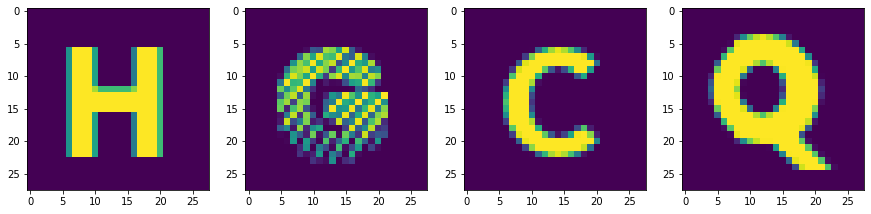

In [8]:

plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(X_train_letters[0].reshape((28,28)))

plt.subplot(142)
plt.imshow(X_train_letters[37].reshape((28,28)))

plt.subplot(143)
plt.imshow(X_train_letters[270].reshape((28,28)))

plt.subplot(144)
plt.imshow(X_train_letters[210].reshape((28,28)))

100%|█████████████████████████████████████████| 100/100 [14:54<00:00,  8.94s/it]


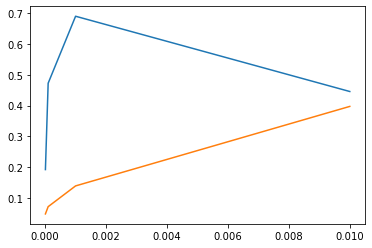

In [20]:
scores_tr = []
scores_te = []
rates = [1e-2,1e-3,1e-4,1e-5]
for rate in rates:
    
    np.random.seed(42)
    nb_classes = len(np.unique(Y_train_letters))
    n_samples = X_train_letters.shape[0]

    neuro_i_1 = 784
    neuro_o_1 = 600
    neuro_i_2 = 600
    neuro_o_2 = 450
    neuro_i_3 = 450
    neuro_o_3 = 300
    neuro_i_4 = 300
    neuro_o_4 = 150
    neuro_i_5 = 150
    neuro_o_5 = 70
    neuro_i_6 = 70
    neuro_o_6 = 26


    facteur_norma = 0.4
    plage_biais = (0,1)
    batch_size = 50
    epochs = 100


    facteur_norma = 0.8
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
    lineaire_4 = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma)
    lineaire_5 = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma)
    lineaire_6 = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma)

    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()
    CE = CrossEntropieLoss(nb_classes)
    softmax = SoftMax()


    network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,TanH,
                      lineaire_4,TanH,lineaire_5,TanH,lineaire_6,softmax]


    network = Sequentiel(network_layers)

    opti = Optim(network,CE,rate)
    opti.SGD(X_train_letters,Y_train_letters,batch_size,epochs)

    scores_tr.append(opti.getNetwork().accuracy(X_train_letters,Y_train_letters))
    scores_te.append(opti.getNetwork().accuracy(X_test_letters,Y_test_letters))
    
    
    
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.show()

In [21]:
rates = np.array(rates)
rate_opt = rates[np.argmax(scores_tr)]
print("Learning rate optimal : ",rate_opt)

Learning rate optimal :  0.001


100%|█████████████████████████████████████████| 100/100 [12:40<00:00,  7.61s/it]


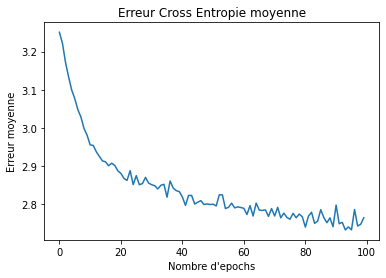

In [3]:
rate_opt = 0.001
np.random.seed(42)
nb_classes = len(np.unique(Y_train_letters))
n_samples = X_train_letters.shape[0]

neuro_i_1 = 784
neuro_o_1 = 600
neuro_i_2 = 600
neuro_o_2 = 450
neuro_i_3 = 450
neuro_o_3 = 300
neuro_i_4 = 300
neuro_o_4 = 150
neuro_i_5 = 150
neuro_o_5 = 70
neuro_i_6 = 70
neuro_o_6 = 26


facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 100


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init='xavier')
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init='xavier')
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init='xavier')
lineaire_4 = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init='xavier')
lineaire_5 = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma,init='xavier')
lineaire_6 = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma,init='xavier')

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,TanH,
                  lineaire_4,TanH,lineaire_5,TanH,lineaire_6,softmax]


network = Sequentiel(network_layers)

opti = Optim(network,CE,rate_opt)
tac = time()
opti.SGD(X_train_letters,Y_train_letters,batch_size,epochs)
tic = time()

opti.affichage(X_train_letters,Y_train_letters)

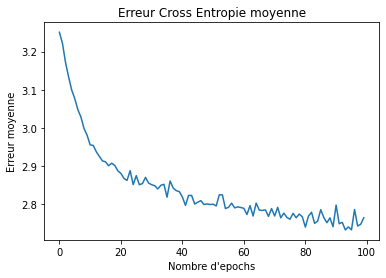

Optimisation finie au bout de  12  min
Train accuracy :  0.8226525949298227
Test accuracy :  0.7128712871287128


In [4]:
#net_to_graph(network, net_name="networks_images/network_MC_alphabets", horizontal=True)


opti.affichage(X_train_letters,Y_train_letters)

print("Optimisation finie au bout de ",int((tic-tac)/60)," min")
print("Train accuracy : ",opti.getNetwork().accuracy(X_train_letters,Y_train_letters))
print("Test accuracy : ",opti.getNetwork().accuracy(X_test_letters,Y_test_letters))

100%|█████████████████████████████████████████| 100/100 [12:41<00:00,  7.61s/it]


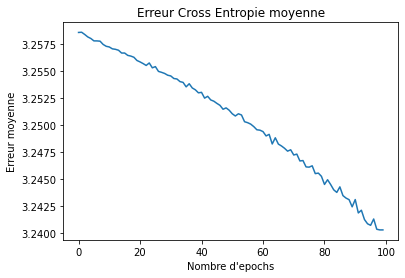

In [5]:
rate_opt = 1e-5
np.random.seed(42)
nb_classes = len(np.unique(Y_train_letters))
n_samples = X_train_letters.shape[0]

neuro_i_1 = 784
neuro_o_1 = 600
neuro_i_2 = 600
neuro_o_2 = 450
neuro_i_3 = 450
neuro_o_3 = 300
neuro_i_4 = 300
neuro_o_4 = 150
neuro_i_5 = 150
neuro_o_5 = 70
neuro_i_6 = 70
neuro_o_6 = 26


facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 100


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma,init='xavier')
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma,init='xavier')
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma,init='xavier')
lineaire_4 = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma,init='xavier')
lineaire_5 = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma,init='xavier')
lineaire_6 = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma,init='xavier')

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,TanH,
                  lineaire_4,TanH,lineaire_5,TanH,lineaire_6,softmax]


network = Sequentiel(network_layers)

opti = Optim(network,CE,rate_opt)
tac = time()
opti.SGD(X_train_letters,Y_train_letters,batch_size,epochs)
tic = time()

opti.affichage(X_train_letters,Y_train_letters)

In [ ]:
#net_to_graph(network, net_name="networks_images/network_MC_alphabets", horizontal=True)


opti.affichage(X_train_letters,Y_train_letters)

print("Optimisation finie au bout de ",int((tic-tac)/60)," min")
print("Train accuracy : ",opti.getNetwork().accuracy(X_train_letters,Y_train_letters))
print("Test accuracy : ",opti.getNetwork().accuracy(X_test_letters,Y_test_letters))

In [3]:
mlp = MLPClassifier(hidden_layer_sizes=(600,450,300,150,70),activation='tanh',batch_size=100,solver='sgd')

tac = time()
mlp.fit(X_train_letters, Y_train_letters)
tic = time()

print("Optimisation finie au bout de ",int((tic-tac)/60)," min")

y_pred = mlp.predict(X_train_letters)
accuracy = accuracy_score(Y_train_letters, y_pred)
print("Train Accuracy: {:.2f}%".format(accuracy * 100))

y_pred = mlp.predict(X_test_letters)
accuracy = accuracy_score(Y_test_letters, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Optimisation finie au bout de  22  min
Train Accuracy: 97.28%
Test Accuracy: 72.63%


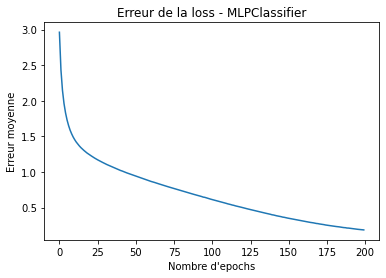

Optimisation finie au bout de  13  min
Train Accuracy: 97.28%
Test Accuracy: 72.63%


In [8]:

plt.title("Erreur de la loss - MLPClassifier")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Erreur moyenne")
plt.plot(mlp.loss_curve_)
plt.show()


print("Optimisation finie au bout de ",int((tic-tac)/60)," min")

y_pred = mlp.predict(X_train_letters)
accuracy = accuracy_score(Y_train_letters, y_pred)
print("Train Accuracy: {:.2f}%".format(accuracy * 100))

y_pred = mlp.predict(X_test_letters)
accuracy = accuracy_score(Y_test_letters, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
